<a href="https://colab.research.google.com/github/TQT2203/BTVN-AI/blob/main/Bai3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

# Đường dẫn đến file zip đã upload
zip_path = "/content/Bai3.zip"  # Đúng đường dẫn khi bạn upload

# Thư mục giải nén
extract_path = "/content/Bai3"

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Đã giải nén thành công!")


✅ Đã giải nén thành công!


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Thư mục chứa dữ liệu gốc sau khi giải nén
dataset_dir = "/content/Bai3/bottle"

# Thư mục đích chứa dữ liệu đã chia
output_dir = "/content/dataset"

# Tạo thư mục train/val và các lớp con
for split in ['train', 'val']:
    for category in ['dat_yeu_cau', 'nap_chai_long', 'nhan_chai_rach', 'sai_mau_nuoc']:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Chia dữ liệu
for category in ['dat_yeu_cau', 'nap_chai_long', 'nhan_chai_rach', 'sai_mau_nuoc']:
    category_path = os.path.join(dataset_dir, category)
    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    train_imgs, val_imgs = train_test_split(images, test_size=0.3, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_dir, 'train', category, img))

    for img in val_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_dir, 'val', category, img))

print("✅ Đã chia tập train/val thành công!")


✅ Đã chia tập train/val thành công!


In [3]:
from PIL import Image
import numpy as np

IMG_SIZE = (640, 640)

def resize_and_normalize_image(image_path, output_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
    img_array = np.array(img) / 255.0
    img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))
    img_normalized.save(output_path)

# Resize tất cả ảnh trong train/val
for split in ['train', 'val']:
    for category in ['dat_yeu_cau', 'nap_chai_long', 'nhan_chai_rach', 'sai_mau_nuoc']:
        folder = os.path.join(output_dir, split, category)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            if os.path.isfile(img_path):
                resize_and_normalize_image(img_path, img_path)

print("✅ Đã resize và chuẩn hóa ảnh thành công!")


✅ Đã resize và chuẩn hóa ảnh thành công!


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(640, 640, 3)),

    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Thêm kiểm tra dữ liệu
class_weights = {0: 1., 1: 1.}  # Cân bằng nếu dataset bị mất cân bằng

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(640, 640),
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/val',
    target_size=(640, 640),
    class_mode='binary'
)

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 640, 640, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 640, 640, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 640, 640, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 640, 640, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 320, 320, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 320, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 320, 320, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 320, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 160, 160, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 160, 160, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 160, 160, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 80, 80, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 80, 80, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 80, 80, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,472,033 (5.62 MB)

 Trainable params: 1,470,113 (5.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

Found 17 images belonging to 5 classes.
Found 11 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - accuracy: 0.4118 - loss: 1.2847 - val_accuracy: 0.3636 - val_loss: 1.8112
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - accuracy: 0.4118 - loss: -0.0428 - val_accuracy: 0.3636 - val_loss: 1.7707
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 96s 96s/step - accuracy: 0.4118 - loss: -1.2070 - val_accuracy: 0.3636 - val_loss: 1.7320
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 95s 95s/step - accuracy: 0.4118 - loss: -1.0073 - val_accuracy: 0.3636 - val_loss: 1.5915
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 152s 152s/step - accuracy: 0.4118 - loss: -4.8651 - val_accuracy: 0.3636 - val_loss: 1.3468
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 95s 95s/step - accuracy: 0.4118 - loss: -8.2731 - val_accuracy: 0.3636 - val_loss: 0.8730
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 96s 96s/step - accuracy: 0.4118 - loss: -10.7831 - val_accuracy: 0.3636 - val_loss: 0.5277
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 95s 95s/step - accuracy: 0.4118 - loss: -9.8717 - val_accuracy: 0.3636 - val

In [5]:
model.save('bai3.h5')

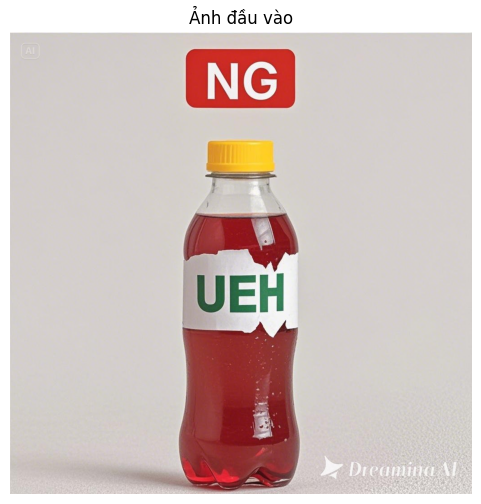

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

🎯 Kết quả phân loại:
✔️ Nhãn dự đoán: Nhãn chai rách
🔢 Xác suất dự đoán: [0.94407684]

❌ Sản phẩm không đạt yêu cầu do: **NHÃN CHAI RÁCH**


In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Tắt OneDNN để tương thích CPU (nếu cần)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Đường dẫn ảnh
image_path = r"/content/nhanchai1.jpeg"

# Đọc ảnh
img = cv2.imread(image_path)

if img is None:
    print("Không thể đọc hình ảnh. Kiểm tra lại đường dẫn:", image_path)
else:
    # Hiển thị ảnh đầu vào
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh đầu vào')
    plt.axis('off')
    plt.show()

    # Tiền xử lý ảnh
    img_resized = cv2.resize(img, (224, 224))
    img_resized = img_resized.astype('float32') / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    # Load mô hình đã huấn luyện
    model = load_model("bai3.h5")

    # Các nhãn lớp (phải khớp thứ tự label trong train_generator.class_indices)
    class_labels = ['Nhãn chai rách','Nắp chai lỏng','Sai màu nước', 'Đạt yêu cầu']

    # Dự đoán
    prediction = model.predict(img_resized)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    label = class_labels[predicted_class]

    print("\n🎯 Kết quả phân loại:")
    print(f"✔️ Nhãn dự đoán: {label}")
    print(f"🔢 Xác suất dự đoán: {prediction[0]}")

    # Diễn giải lỗi nếu không đạt yêu cầu
    if label == "Đạt yêu cầu":
        print("\n✅ Sản phẩm đạt yêu cầu.")
    else:
        print(f"\n❌ Sản phẩm không đạt yêu cầu do: **{label.replace('_', ' ').upper()}**")
        if confidence < 0.5:
            print(f"⚠️ Độ tin cậy thấp: {confidence:.4f}")


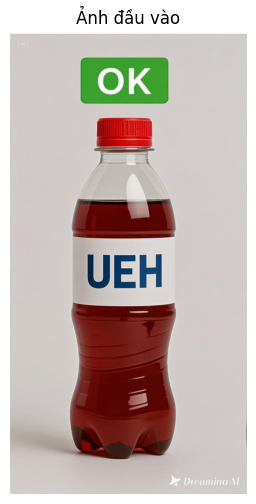

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
 Nhãn dự đoán: Đạt yêu cầu
 Xác suất dự đoán: [0.91845363]

✅ Sản phẩm đạt yêu cầu.


In [21]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Tắt OneDNN để tương thích CPU (nếu cần)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Đường dẫn ảnh
image_path = r"/content/chai.jpeg"

# Đọc ảnh
img = cv2.imread(image_path)

if img is None:
    print("Không thể đọc hình ảnh. Kiểm tra lại đường dẫn:", image_path)
else:
    # Hiển thị ảnh đầu vào
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh đầu vào')
    plt.axis('off')
    plt.show()

    # Tiền xử lý ảnh
    img_resized = cv2.resize(img, (224, 224))
    img_resized = img_resized.astype('float32') / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    # Load mô hình đã huấn luyện
    model = load_model("bai3.h5")

    # Các nhãn lớp (phải khớp thứ tự label trong train_generator.class_indices)
    class_labels = ['Đạt yêu cầu','Nhãn chai rách','Nắp chai lỏng','Sai màu nước' ]

    # Dự đoán
    prediction = model.predict(img_resized)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    label = class_labels[predicted_class]


    print(f" Nhãn dự đoán: {label}")
    print(f" Xác suất dự đoán: {prediction[0]}")

    # Diễn giải lỗi nếu không đạt yêu cầu
    if label == "Đạt yêu cầu":
        print("\n✅ Sản phẩm đạt yêu cầu.")
    else:
        print(f"\n❌ Sản phẩm không đạt yêu cầu do: **{label.replace('_', ' ').upper()}**")